# Falsification of User-Given Directed Acyclic Graphs
This notebook demonstrates a tool on falsifying a user-given DAG using observational data. The main function is `falsify_graph()`, which takes as input a DAG and data and returns an evaluation result.
For more details about this method, please read the related paper:

> Eulig, E., Mastakouri, A. A., Blöbaum, P., Hardt, M., & Janzing, D. (2023). Toward Falsifying Causal Graphs Using a Permutation-Based Test. https://arxiv.org/abs/2305.09565

In [1]:
# Import the necessary libraries and functions for this demo
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import GradientBoostingRegressor
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel

# Set random seed
set_random_seed(1332)

### Synthetic Data
We will first demonstrate the tool on synthetic data. To this end we generated a random DAG with 5 nodes `falsify_g_true.gml` and some data from a random SCM with nonlinear conditionals (`falsify_data_nonlinear.csv`).

True DAG


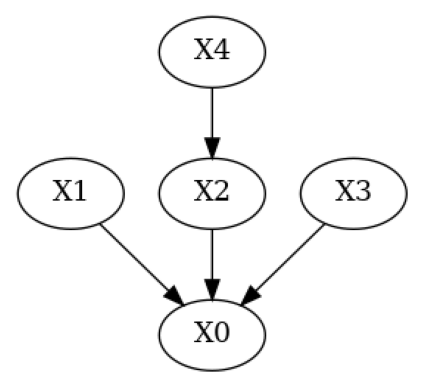

In [2]:
# Load example graph and data
g_true = nx.read_gml(f"falsify_g_true.gml")
data = pd.read_csv(f"falsify_data_nonlinear.csv")

# Plot true DAG
print("True DAG")
plot(g_true)

Let's first evaluate the true DAG on that data (the following cell will take approximately 20s to run)

Test permutations of given graph:   0%|          | 0/20 [00:00<?, ?it/s]

Test permutations of given graph:   5%|▌         | 1/20 [00:01<00:26,  1.42s/it]

Test permutations of given graph:  10%|█         | 2/20 [00:02<00:24,  1.38s/it]

Test permutations of given graph:  15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

Test permutations of given graph:  20%|██        | 4/20 [00:04<00:18,  1.16s/it]

Test permutations of given graph:  25%|██▌       | 5/20 [00:05<00:15,  1.06s/it]

Test permutations of given graph:  30%|███       | 6/20 [00:06<00:14,  1.01s/it]

Test permutations of given graph:  35%|███▌      | 7/20 [00:08<00:14,  1.10s/it]

Test permutations of given graph:  40%|████      | 8/20 [00:08<00:12,  1.03s/it]

Test permutations of given graph:  45%|████▌     | 9/20 [00:10<00:12,  1.11s/it]

Test permutations of given graph:  50%|█████     | 10/20 [00:11<00:11,  1.16s/it]

Test permutations of given graph:  60%|██████    | 12/20 [00:12<00:06,  1.23it/s]

Test permutations of given graph:  65%|██████▌   | 13/20 [00:13<00:05,  1.22it/s]

Test permutations of given graph:  70%|███████   | 14/20 [00:14<00:05,  1.19it/s]

Test permutations of given graph:  85%|████████▌ | 17/20 [00:14<00:01,  1.83it/s]

Test permutations of given graph:  90%|█████████ | 18/20 [00:15<00:01,  1.65it/s]

Test permutations of given graph:  95%|█████████▌| 19/20 [00:16<00:00,  1.52it/s]

Test permutations of given graph: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]

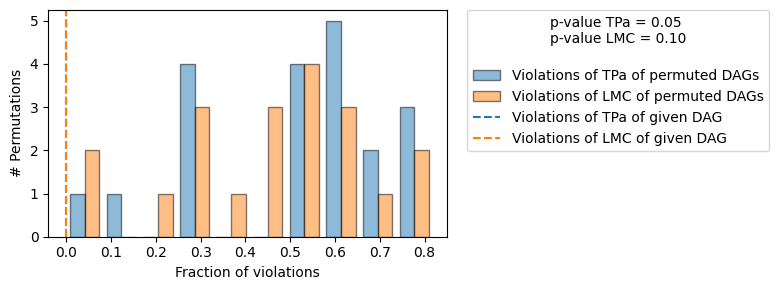

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 1 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.05).                                                   |
| The given DAG violates 0/11 LMCs and is better than 90.0% of the permuted DAGs (p-value: 0.10).       |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [3]:
result = falsify_graph(g_true, data, plot_histogram=True)
# Summarize the result
print(result)

As expected, we do not reject the true DAG. Let's understand what `falsify_graph()` does exactly: When we provide a given DAG to `falsify_graph()`, we test violations of local Markov conditions (LMC) by running conditional independence tests (CIs). I.e. for each node in the graph we test if
$$ X_i \perp \!\!\! \perp_P X_j \in \text{NonDesc}_{X_i} \ | \ \text{PA}_{X_i} $$
We then randomly permute the nodes of the given DAG and test violations of LMC again. We can do this for either a fixed amount of permutations or for all $n!,n:$ Number of nodes in the given DAG. We can then use the probability of a random node permutation (the null) having as few or fewer violations as the given DAG (the test statistic) as a measure to validate the given DAG (the p-value reported in the upper-right corner in the plot above).

Similarly, we can run an oracle test for each permutation w.r.t. the given DAG, i.e. if the given DAG were the true DAG, how many violations of LMCs do we expect for some permutation. Note, that asking about the number of permutations violating zero LMCs is identical to asking about how many DAGs lie in the same Markov equivalence class (MEC) as the given DAG. In our method we use the number of permuted DAGs lying in the same MEC as the given DAG (with 0 #Violations of tPA) as a measure of how informative the given DAG is. Only if few permutations lie in the same MEC, the independences entailed by the given DAG are 'characteristic' in the sense that the given DAG is falsifiable by testing implied CIs.

In the plot above we see histograms of the LMC violations of permuted DAGs (blue) and d-separation (oracle, orange) violations of the permuted DAGs. The dashed orange and blue line indicate the number of violations of LMC (blue) / d-separation (orange) of the given DAG. As expected for the true DAG, both histograms are broadly overlapping (except for statistical errors in the CI tests).

If we are not interested in the plot and just wish to know whether a given is falsified using our test we can use the `falsified` attribute of the returned `EvaluationResult` object of `falsify_graph()` instead.

In [4]:
print(f"Graph is falsifiable: {result.falsifiable}, Graph is falsified: {result.falsified}")

Graph is falsifiable: True, Graph is falsified: False


Now, let's modify the true DAG to simulate a DAG where a domain expert knows some of the edges but removes a true one and introduces a wrong one.

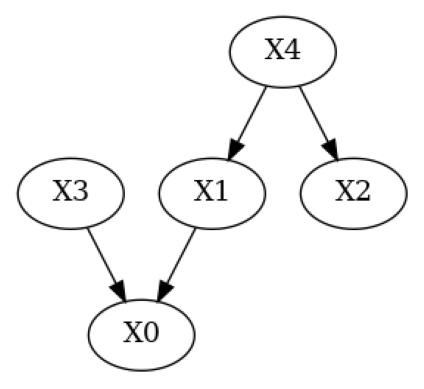

In [5]:
# Simulate a domain expert with knowledge over some of the edges in the system
g_given = g_true.copy()
g_given.add_edges_from(([('X4', 'X1')]))  # Add wrong edge from X4 -> X1
g_given.remove_edge('X2', 'X0')  # Remove true edge from X2 -> X0
plot(g_given)

Test permutations of given graph:   0%|          | 0/20 [00:00<?, ?it/s]

Test permutations of given graph:   5%|▌         | 1/20 [00:02<00:45,  2.41s/it]

Test permutations of given graph:  10%|█         | 2/20 [00:04<00:43,  2.42s/it]

Test permutations of given graph:  15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

Test permutations of given graph:  20%|██        | 4/20 [00:08<00:30,  1.90s/it]

Test permutations of given graph:  25%|██▌       | 5/20 [00:09<00:26,  1.80s/it]

Test permutations of given graph:  30%|███       | 6/20 [00:11<00:22,  1.62s/it]

Test permutations of given graph:  35%|███▌      | 7/20 [00:12<00:19,  1.50s/it]

Test permutations of given graph:  40%|████      | 8/20 [00:13<00:17,  1.43s/it]

Test permutations of given graph:  45%|████▌     | 9/20 [00:14<00:15,  1.38s/it]

Test permutations of given graph:  60%|██████    | 12/20 [00:16<00:06,  1.19it/s]

Test permutations of given graph:  65%|██████▌   | 13/20 [00:17<00:06,  1.16it/s]

Test permutations of given graph:  75%|███████▌  | 15/20 [00:17<00:03,  1.42it/s]

Test permutations of given graph: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]

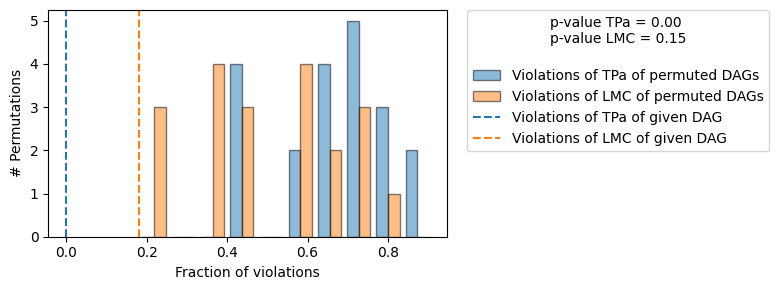

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 2/11 LMCs and is better than 85.0% of the permuted DAGs (p-value: 0.15).       |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we reject the DAG.                                                                                    |
+-------------------------------------------------------------------------------------------------------+


In [6]:
# Run evaluation and plot the result using `plot=True`
result = falsify_graph(g_given, data, plot_histogram=True)
# Summarize the result
print(result)

Here, we observe two things. First, the given DAG violates 2 more LMCs than the true DAG. Second, there are many permuted DAGs that violate as many or less LMCs as the given DAG. This is reflected in the p-value LMC, which is much higher than before. Based on the default significance level of 0.05 we would therefore reject the given DAG.

We can gain additional insight by highlighting the nodes for which the violations of LMCs occurred in the given DAG.

Violations of LMCs


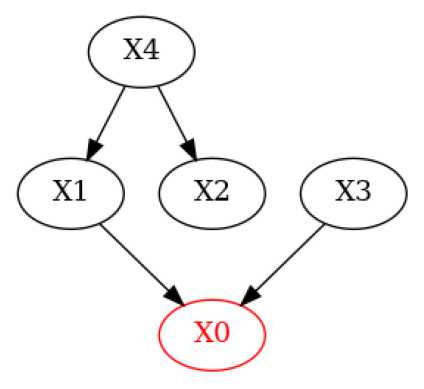

In [7]:
# Plot nodes for which violations of LMCs occured
print('Violations of LMCs')
plot_local_insights(g_given, result, method=FalsifyConst.VALIDATE_LMC)

### Real Data (Protein Network dataset by Sachs et al., 2005)
Let's try our evaluation method on some real data, the protein network data from Sachs et al., 2005 [1]. This dataset contains quantitative measurements of the expression levels of $n=11$ phosphorylated proteins and phospholipids in the human primary T cell signaling network. The $N=7,466$ measurements, corresponding to individual cells, were acquired via intracellular multicolor flow cytometry. The consensus network contains 19 directed edges with no cycles.  
[1] https://www.science.org/doi/abs/10.1126/science.1105809

In [8]:
# Load the data and consensus DAG
data_url = "https://raw.githubusercontent.com/FenTechSolutions/CausalDiscoveryToolbox/master/cdt/data/resources/cyto_full_data.csv"
data_sachs = pd.read_csv(data_url)
g_sachs = nx.read_gml('falsify_sachs.gml')

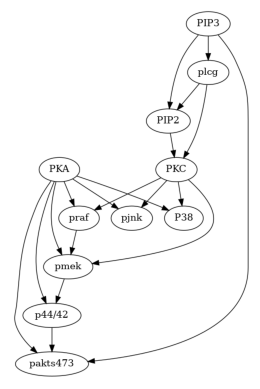

In [9]:
plot(g_sachs)

Because of the large number of samples, evaluation using the kernel test above takes too long for this demo. Therefore, we’ll use a test based on the generalized covariance measure (GCM) instead. We'll use sklearns gradient boosted decision trees as regressors.

In [10]:
# Define independence test based on the generalised covariance measure with gradient boosted decision trees as models
def create_gradient_boost_regressor(**kwargs) -> SklearnRegressionModel:
    return SklearnRegressionModel(GradientBoostingRegressor(**kwargs))
def gcm(X, Y, Z=None):
    return generalised_cov_based(X, Y, Z=Z, prediction_model_X=create_gradient_boost_regressor,
                                 prediction_model_Y=create_gradient_boost_regressor)

It is infeasible (and unnecessary) to run our baseline on all 11! node-permutations of the graph. We therefore set `n_permutations=100` to evaluate using 100 random permutations. To use the GCM test defined above we'll use the parameters `independence_test=gcm` (unconditional independence testing) and `conditional_independence_test=gcm` (conditional independence testing).

The following cell will take about 3min to run.

Test permutations of given graph:   0%|          | 0/100 [00:00<?, ?it/s]

Test permutations of given graph:   1%|          | 1/100 [00:10<16:33, 10.04s/it]

Test permutations of given graph:   2%|▏         | 2/100 [00:19<16:16,  9.96s/it]

Test permutations of given graph:   3%|▎         | 3/100 [00:29<15:52,  9.82s/it]

Test permutations of given graph:   4%|▍         | 4/100 [00:39<15:49,  9.89s/it]

Test permutations of given graph:   5%|▌         | 5/100 [00:49<15:51, 10.01s/it]

Test permutations of given graph:   6%|▌         | 6/100 [00:58<15:04,  9.62s/it]

Test permutations of given graph:   7%|▋         | 7/100 [01:05<13:41,  8.83s/it]

Test permutations of given graph:   8%|▊         | 8/100 [01:15<14:07,  9.22s/it]

Test permutations of given graph:   9%|▉         | 9/100 [01:26<14:25,  9.51s/it]

Test permutations of given graph:  10%|█         | 10/100 [01:35<14:21,  9.57s/it]

Test permutations of given graph:  11%|█         | 11/100 [01:45<14:11,  9.57s/it]

Test permutations of given graph:  12%|█▏        | 12/100 [01:54<14:01,  9.56s/it]

Test permutations of given graph:  13%|█▎        | 13/100 [02:03<13:23,  9.23s/it]

Test permutations of given graph:  14%|█▍        | 14/100 [02:10<12:22,  8.63s/it]

Test permutations of given graph:  15%|█▌        | 15/100 [02:20<12:39,  8.93s/it]

Test permutations of given graph:  16%|█▌        | 16/100 [02:29<12:46,  9.13s/it]

Test permutations of given graph:  17%|█▋        | 17/100 [02:36<11:34,  8.37s/it]

Test permutations of given graph:  18%|█▊        | 18/100 [02:45<11:53,  8.71s/it]

Test permutations of given graph:  19%|█▉        | 19/100 [02:55<12:01,  8.91s/it]

Test permutations of given graph:  20%|██        | 20/100 [03:02<11:12,  8.41s/it]

Test permutations of given graph:  21%|██        | 21/100 [03:12<11:30,  8.74s/it]

Test permutations of given graph:  22%|██▏       | 22/100 [03:21<11:38,  8.96s/it]

Test permutations of given graph:  23%|██▎       | 23/100 [03:27<10:21,  8.07s/it]

Test permutations of given graph:  24%|██▍       | 24/100 [03:35<10:05,  7.96s/it]

Test permutations of given graph:  25%|██▌       | 25/100 [03:44<10:27,  8.37s/it]

Test permutations of given graph:  26%|██▌       | 26/100 [03:52<10:08,  8.22s/it]

Test permutations of given graph:  27%|██▋       | 27/100 [03:59<09:39,  7.93s/it]

Test permutations of given graph:  28%|██▊       | 28/100 [04:08<09:46,  8.14s/it]

Test permutations of given graph:  29%|██▉       | 29/100 [04:17<10:03,  8.50s/it]

Test permutations of given graph:  30%|███       | 30/100 [04:24<09:11,  7.87s/it]

Test permutations of given graph:  31%|███       | 31/100 [04:30<08:41,  7.56s/it]

Test permutations of given graph:  32%|███▏      | 32/100 [04:38<08:33,  7.56s/it]

Test permutations of given graph:  33%|███▎      | 33/100 [04:45<08:18,  7.44s/it]

Test permutations of given graph:  34%|███▍      | 34/100 [04:52<07:58,  7.25s/it]

Test permutations of given graph:  35%|███▌      | 35/100 [05:00<08:14,  7.60s/it]

Test permutations of given graph:  36%|███▌      | 36/100 [05:08<08:15,  7.74s/it]

Test permutations of given graph:  37%|███▋      | 37/100 [05:15<07:54,  7.53s/it]

Test permutations of given graph:  38%|███▊      | 38/100 [05:20<06:59,  6.77s/it]

Test permutations of given graph:  39%|███▉      | 39/100 [05:30<07:42,  7.59s/it]

Test permutations of given graph:  40%|████      | 40/100 [05:37<07:33,  7.56s/it]

Test permutations of given graph:  41%|████      | 41/100 [05:43<06:50,  6.97s/it]

Test permutations of given graph:  42%|████▏     | 42/100 [05:52<07:13,  7.47s/it]

Test permutations of given graph:  43%|████▎     | 43/100 [05:57<06:24,  6.74s/it]

Test permutations of given graph:  44%|████▍     | 44/100 [06:03<06:17,  6.75s/it]

Test permutations of given graph:  45%|████▌     | 45/100 [06:11<06:21,  6.93s/it]

Test permutations of given graph:  46%|████▌     | 46/100 [06:14<05:06,  5.69s/it]

Test permutations of given graph:  47%|████▋     | 47/100 [06:21<05:29,  6.22s/it]

Test permutations of given graph:  48%|████▊     | 48/100 [06:27<05:18,  6.12s/it]

Test permutations of given graph:  49%|████▉     | 49/100 [06:35<05:47,  6.82s/it]

Test permutations of given graph:  50%|█████     | 50/100 [06:40<05:05,  6.10s/it]

Test permutations of given graph:  51%|█████     | 51/100 [06:48<05:22,  6.59s/it]

Test permutations of given graph:  52%|█████▏    | 52/100 [06:56<05:43,  7.15s/it]

Test permutations of given graph:  53%|█████▎    | 53/100 [07:01<05:05,  6.51s/it]

Test permutations of given graph:  54%|█████▍    | 54/100 [07:08<05:00,  6.53s/it]

Test permutations of given graph:  55%|█████▌    | 55/100 [07:15<05:08,  6.86s/it]

Test permutations of given graph:  56%|█████▌    | 56/100 [07:19<04:26,  6.06s/it]

Test permutations of given graph:  57%|█████▋    | 57/100 [07:25<04:20,  6.05s/it]

Test permutations of given graph:  58%|█████▊    | 58/100 [07:32<04:18,  6.16s/it]

Test permutations of given graph:  59%|█████▉    | 59/100 [07:36<03:46,  5.53s/it]

Test permutations of given graph:  60%|██████    | 60/100 [07:43<03:57,  5.94s/it]

Test permutations of given graph:  61%|██████    | 61/100 [07:47<03:31,  5.42s/it]

Test permutations of given graph:  62%|██████▏   | 62/100 [07:52<03:24,  5.38s/it]

Test permutations of given graph:  63%|██████▎   | 63/100 [07:58<03:20,  5.42s/it]

Test permutations of given graph:  64%|██████▍   | 64/100 [08:04<03:27,  5.76s/it]

Test permutations of given graph:  65%|██████▌   | 65/100 [08:10<03:15,  5.58s/it]

Test permutations of given graph:  66%|██████▌   | 66/100 [08:14<02:58,  5.24s/it]

Test permutations of given graph:  67%|██████▋   | 67/100 [08:20<02:56,  5.36s/it]

Test permutations of given graph:  68%|██████▊   | 68/100 [08:24<02:38,  4.94s/it]

Test permutations of given graph:  69%|██████▉   | 69/100 [08:30<02:50,  5.49s/it]

Test permutations of given graph:  70%|███████   | 70/100 [08:39<03:11,  6.37s/it]

Test permutations of given graph:  71%|███████   | 71/100 [08:44<02:52,  5.96s/it]

Test permutations of given graph:  72%|███████▏  | 72/100 [08:50<02:49,  6.07s/it]

Test permutations of given graph:  73%|███████▎  | 73/100 [08:53<02:21,  5.25s/it]

Test permutations of given graph:  74%|███████▍  | 74/100 [08:59<02:21,  5.45s/it]

Test permutations of given graph:  75%|███████▌  | 75/100 [09:04<02:08,  5.13s/it]

Test permutations of given graph:  76%|███████▌  | 76/100 [09:08<01:56,  4.86s/it]

Test permutations of given graph:  77%|███████▋  | 77/100 [09:13<01:51,  4.86s/it]

Test permutations of given graph:  78%|███████▊  | 78/100 [09:18<01:48,  4.93s/it]

Test permutations of given graph:  79%|███████▉  | 79/100 [09:22<01:38,  4.70s/it]

Test permutations of given graph:  80%|████████  | 80/100 [09:28<01:42,  5.13s/it]

Test permutations of given graph:  81%|████████  | 81/100 [09:33<01:32,  4.87s/it]

Test permutations of given graph:  82%|████████▏ | 82/100 [09:37<01:24,  4.71s/it]

Test permutations of given graph:  83%|████████▎ | 83/100 [09:41<01:17,  4.54s/it]

Test permutations of given graph:  84%|████████▍ | 84/100 [09:48<01:24,  5.26s/it]

Test permutations of given graph:  85%|████████▌ | 85/100 [09:53<01:16,  5.09s/it]

Test permutations of given graph:  86%|████████▌ | 86/100 [10:00<01:18,  5.63s/it]

Test permutations of given graph:  87%|████████▋ | 87/100 [10:06<01:14,  5.73s/it]

Test permutations of given graph:  88%|████████▊ | 88/100 [10:12<01:11,  6.00s/it]

Test permutations of given graph:  89%|████████▉ | 89/100 [10:16<00:57,  5.24s/it]

Test permutations of given graph:  90%|█████████ | 90/100 [10:21<00:53,  5.32s/it]

Test permutations of given graph:  91%|█████████ | 91/100 [10:24<00:41,  4.64s/it]

Test permutations of given graph:  92%|█████████▏| 92/100 [10:29<00:38,  4.78s/it]

Test permutations of given graph:  93%|█████████▎| 93/100 [10:35<00:35,  5.09s/it]

Test permutations of given graph:  94%|█████████▍| 94/100 [10:38<00:26,  4.46s/it]

Test permutations of given graph:  95%|█████████▌| 95/100 [10:45<00:26,  5.22s/it]

Test permutations of given graph:  96%|█████████▌| 96/100 [10:49<00:19,  4.95s/it]

Test permutations of given graph:  97%|█████████▋| 97/100 [10:54<00:14,  4.99s/it]

Test permutations of given graph:  98%|█████████▊| 98/100 [10:56<00:08,  4.05s/it]

Test permutations of given graph:  99%|█████████▉| 99/100 [11:02<00:04,  4.60s/it]

Test permutations of given graph: 100%|██████████| 100/100 [11:04<00:00,  3.78s/it]

Test permutations of given graph: 100%|██████████| 100/100 [11:04<00:00,  6.65s/it]

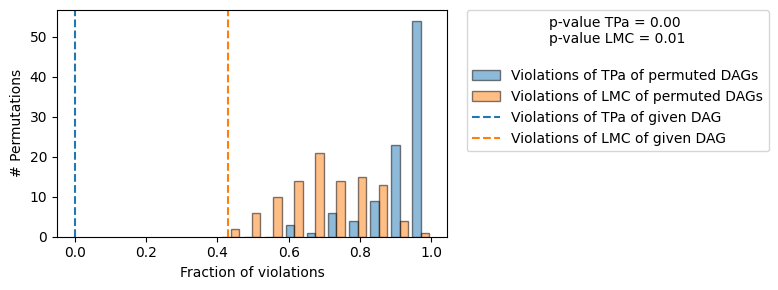

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 100 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 21/49 LMCs and is better than 99.0% of the permuted DAGs (p-value: 0.01).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [11]:
# Run evaluation for consensus graph and data.
result_sachs = falsify_graph(g_sachs, data_sachs, n_permutations=100,
                              independence_test=gcm, 
                              conditional_independence_test=gcm, 
                              plot_histogram=True)
print(result_sachs)

We observe that the consensus DAG is both informative (0/100 permutations lie in the same MEC) and significantly better than random in terms of CI it entails. Note, that the number of LMC violations of the given DAG are much more than the expected type I error rate of the CI tests for the default significance level `significance_ci=0.05` used here. The naive approach of rejecting a DAG with more than 5% violations of LMC would thus falsly reject this DAG.

### Edge Suggestions
Beyond falsification of a given DAG shown above we can also run additional tests using `suggestions=True` and report those back to the user. To demonstrate this we will use the synthetic DAG and data from before.

Test permutations of given graph:   0%|          | 0/20 [00:00<?, ?it/s]

Test permutations of given graph:   5%|▌         | 1/20 [00:02<00:46,  2.42s/it]

Test permutations of given graph:  10%|█         | 2/20 [00:04<00:43,  2.44s/it]

Test permutations of given graph:  15%|█▌        | 3/20 [00:06<00:35,  2.06s/it]

Test permutations of given graph:  20%|██        | 4/20 [00:07<00:27,  1.74s/it]

Test permutations of given graph:  25%|██▌       | 5/20 [00:10<00:29,  1.99s/it]

Test permutations of given graph:  30%|███       | 6/20 [00:11<00:22,  1.62s/it]

Test permutations of given graph:  35%|███▌      | 7/20 [00:12<00:20,  1.61s/it]

Test permutations of given graph:  40%|████      | 8/20 [00:13<00:16,  1.38s/it]

Test permutations of given graph:  55%|█████▌    | 11/20 [00:14<00:06,  1.34it/s]

Test permutations of given graph:  65%|██████▌   | 13/20 [00:15<00:04,  1.52it/s]

Test permutations of given graph:  70%|███████   | 14/20 [00:16<00:04,  1.42it/s]

Test permutations of given graph:  75%|███████▌  | 15/20 [00:17<00:03,  1.36it/s]

Test permutations of given graph:  80%|████████  | 16/20 [00:18<00:03,  1.05it/s]

Test permutations of given graph: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]

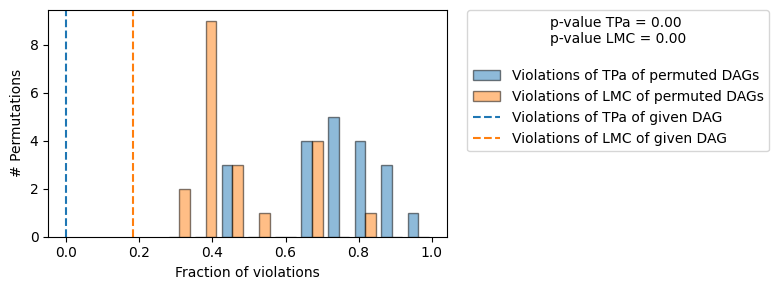

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 2/11 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
|                                             

In [12]:
result = falsify_graph(g_given, data, plot_histogram=True, suggestions=True)
print(result)

Compared to the output above we now see the additional row `Suggestions` in the print representation of the evaluation summary. We used a test of causal minimality to report suggestions to the user and would correctly suggest the removal of the edge $X4 \to X1$, which was wrongly added by the domain expert. We can also plot those suggestions using `plot_local_insights`:

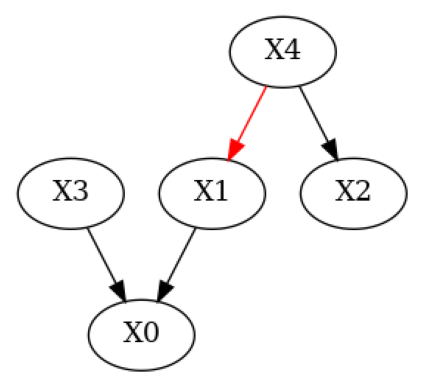

In [13]:
# Plot suggestions
plot_local_insights(g_given, result, method=FalsifyConst.VALIDATE_CM)

We can apply those suggestions using `apply_suggestions`. If there is an edge we do not want to remove we can use the additional parameter `edges_to_keep` to specify which edges we would not want to be removed.

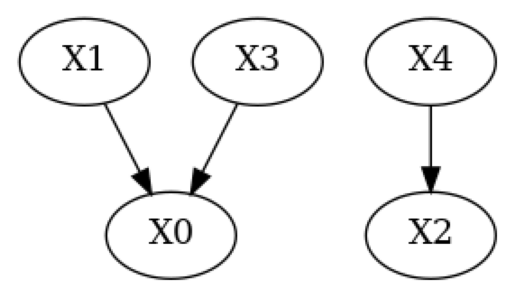

In [14]:
# Apply all suggestions (we could exclude suggestions via `edges_to_keep=[('X3', 'X4')])`)
g_given_pruned = apply_suggestions(g_given, result)
# Plot pruned DAG
plot(g_given_pruned)